In [1]:
## This Noteboook generates Figure 4 in Ori et al., 2020 
## It is based on Foregut Endoderm + Early Lung Progenitor subset generated in generate_subsets.ipynb

## Following Table is produced:
#  data/Suppl_Table_8_diffxpy_FE_ELP_traj.xlsx

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import re

from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)
gray_green = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "limegreen", "forestgreen"], N = 128)
gray_blue = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "skyblue", "royalblue"], N = 128)

colorsComb = np.vstack([plt.cm.RdBu_r(np.linspace(0.3, 0.9, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
hmap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

### Read in Foregut Endoderm and Early Lung Progenitor subset

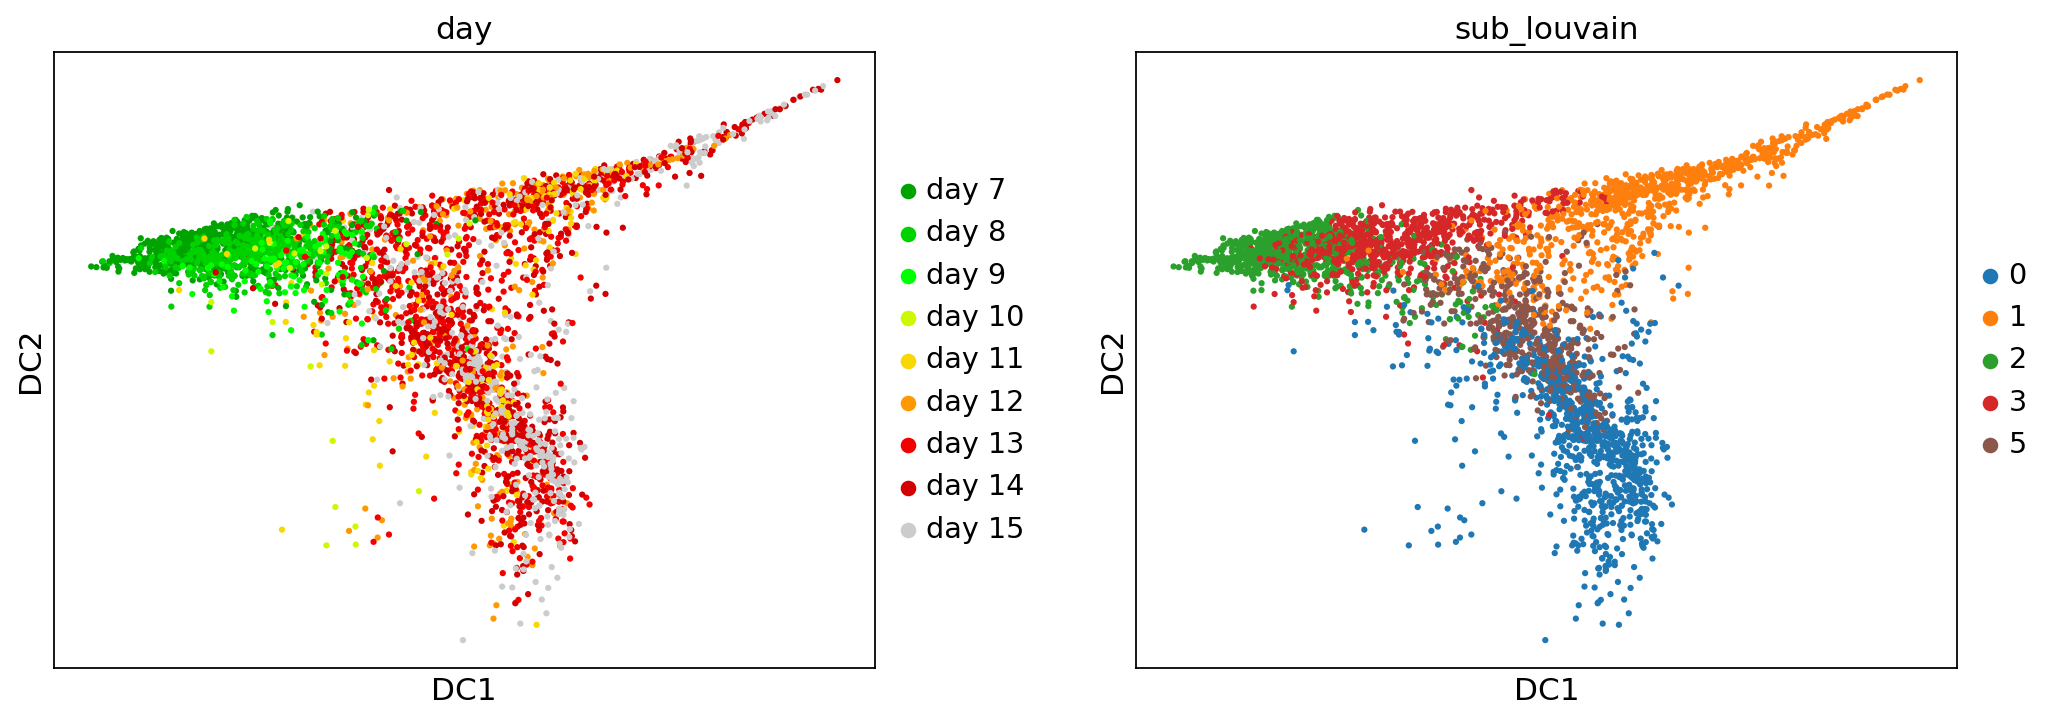

In [17]:
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6.5, 5)

folder = "/20200806_Drukker_IPSlungProgenitors_meshal.ansari/"
sub = sc.read(folder + "IPS_lung_differentiation_forendo_elungpro.h5ad")

## Subset to only cluster that end up in either lung or hepatocyte branch
sub = sub[sub.obs["sub_louvain"].isin(["0", "1", "2", "3", "5"])].copy()
sc.pl.diffmap(sub, color = ["day", "sub_louvain"], wspace = 0.2)

### Figure 4 a - Diffusion map overlaid with PAGA

In [4]:
sc.tl.paga(sub, groups = "sub_louvain")
sc.pl.paga_compare(sub, basis = "diffmap", show = False)

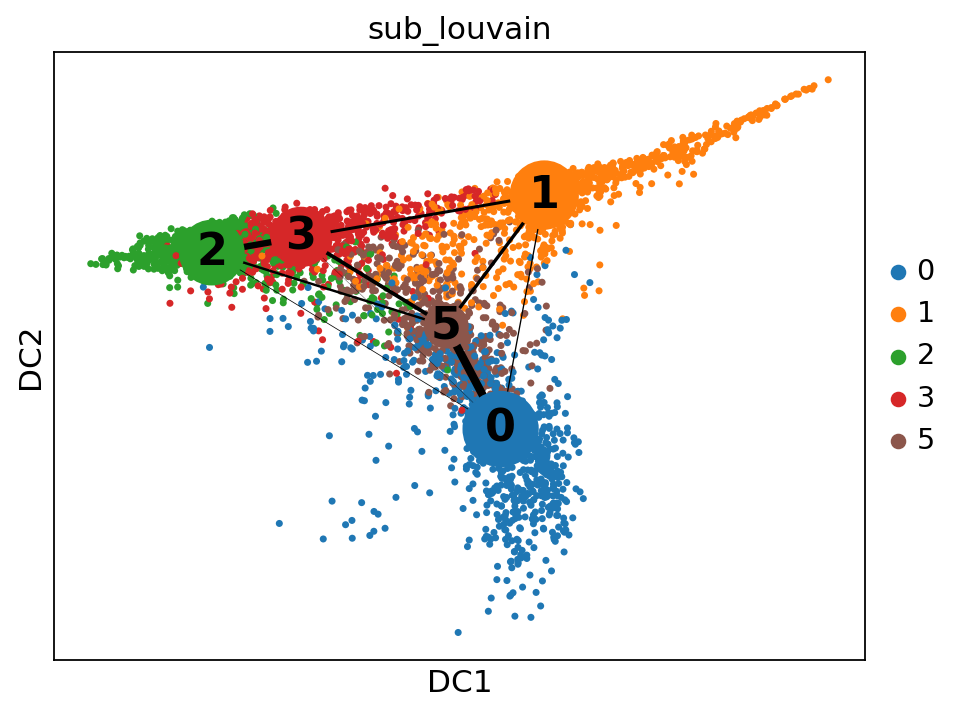

In [5]:
fig1, ax1 = plt.subplots(figsize=(6.5, 5))
sc.pl.diffmap(sub, size = 40, ax = ax1, show = False, color = "sub_louvain")
sc.pl.paga(sub, pos = sub.uns['paga']['pos'], show = False, node_size_power = 2,
           node_size_scale = 5, ax = ax1, text_kwds={'fontsize': 20})
plt.show()

### Figure 4 b - Diffusion map coloured coded by differentiation stage 

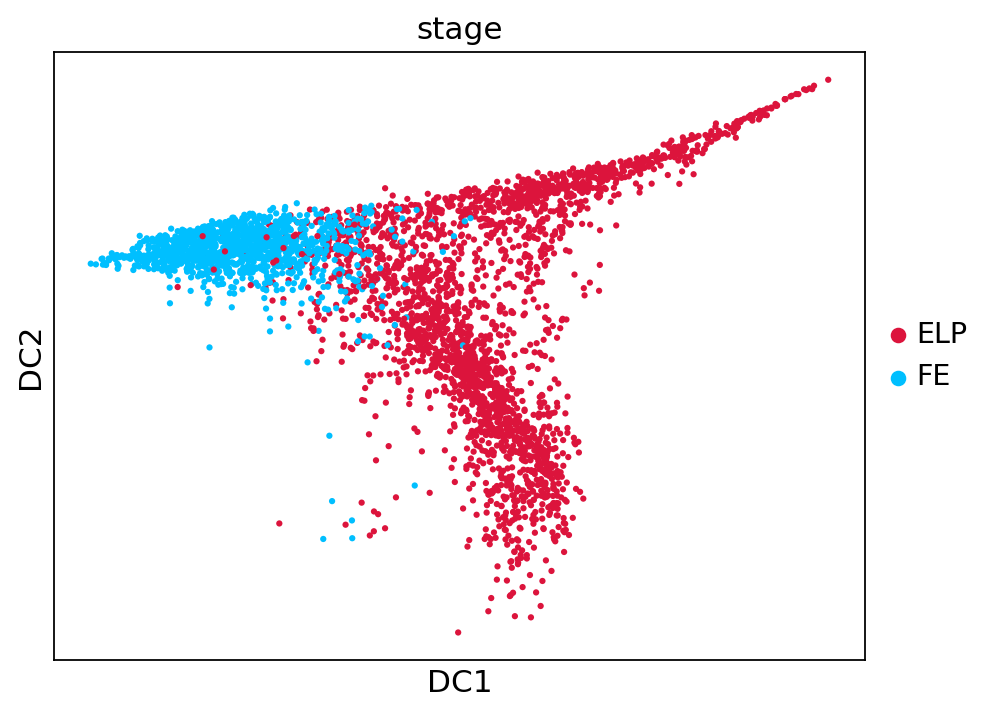

In [6]:
sc.pl.diffmap(sub, color = ["stage"])

### Figure 4 c, d - Diffusion map coloured by lung and hepatocyte score

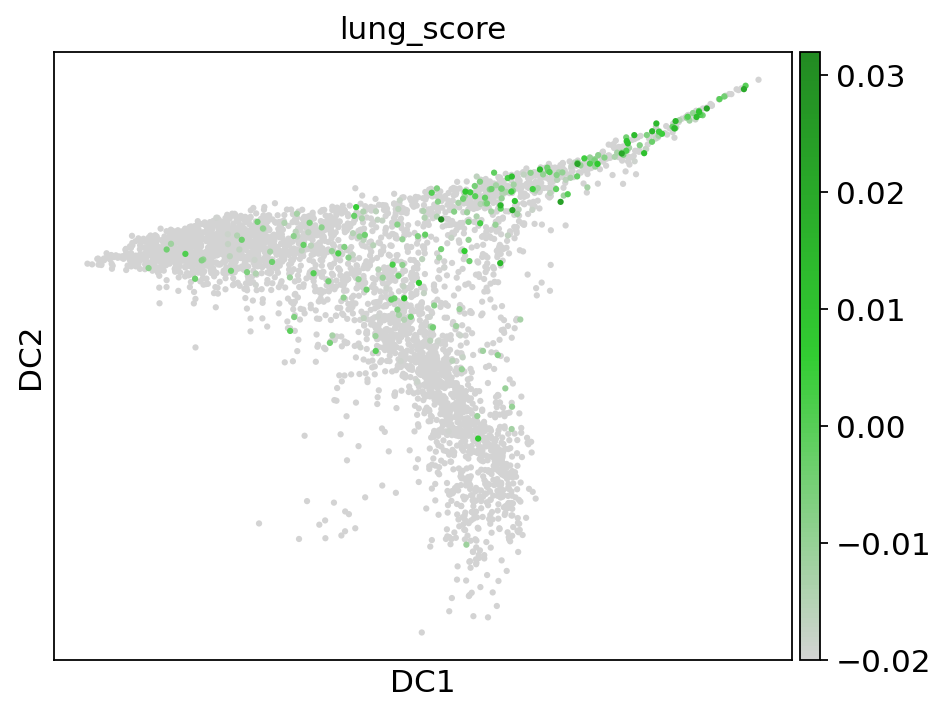

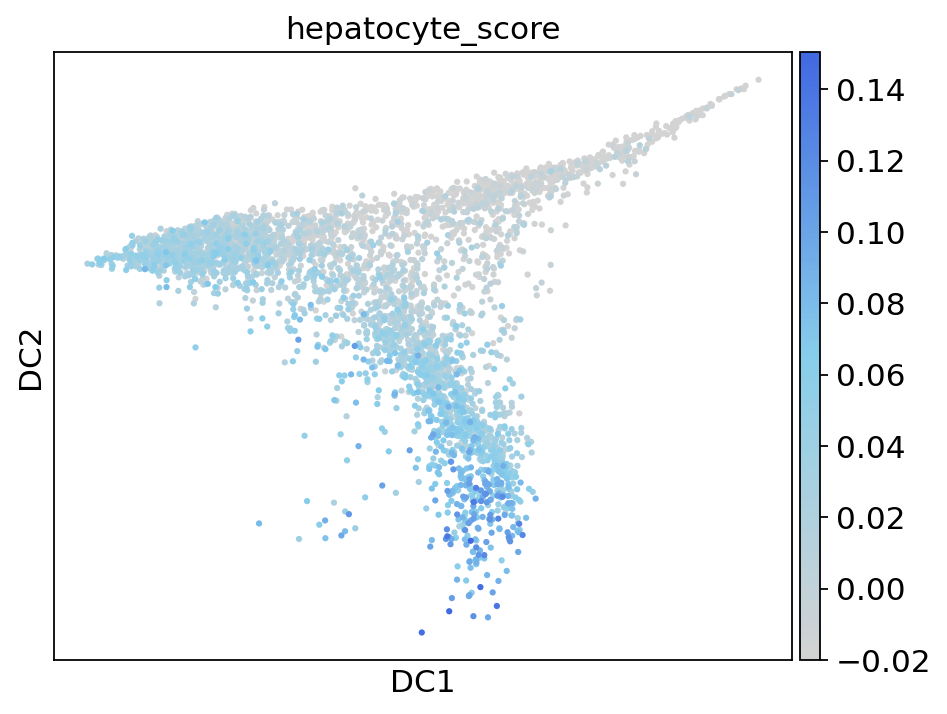

In [7]:
## Read differential gene expression Result Table based on Bulk data (GFP+ vs GFP-)
## Select those genes with logFC > 1 as lung genes and logFC < -1 as non lung genes
markers = pd.read_csv(folder + "GFPpos_vs_GFPneg_bulk.txt", sep = "\t", decimal = ",")

lung_genes = markers[markers["log2FoldChange"] > 1].symbol
lung_genes = [g for g in lung_genes if g in sub.var_names]

non_lung_genes = markers[markers["log2FoldChange"] < -1].symbol
non_lung_genes = [g for g in non_lung_genes if g in sub.var_names]

## Score based on these signatures
sc.tl.score_genes(sub, gene_list = lung_genes, score_name = "lung_score")
sc.tl.score_genes(sub, gene_list = non_lung_genes, score_name = "hepatocyte_score")

sc.pl.diffmap(sub, color = "lung_score", cmap = gray_green, vmin = -0.02)
sc.pl.diffmap(sub, color = "hepatocyte_score", cmap = gray_blue, vmin = -0.02)

### Figure 4 e - Find gene with significant time pattern and differentially expressed in the two potential branches

... storing 'dpt_bins' as categorical


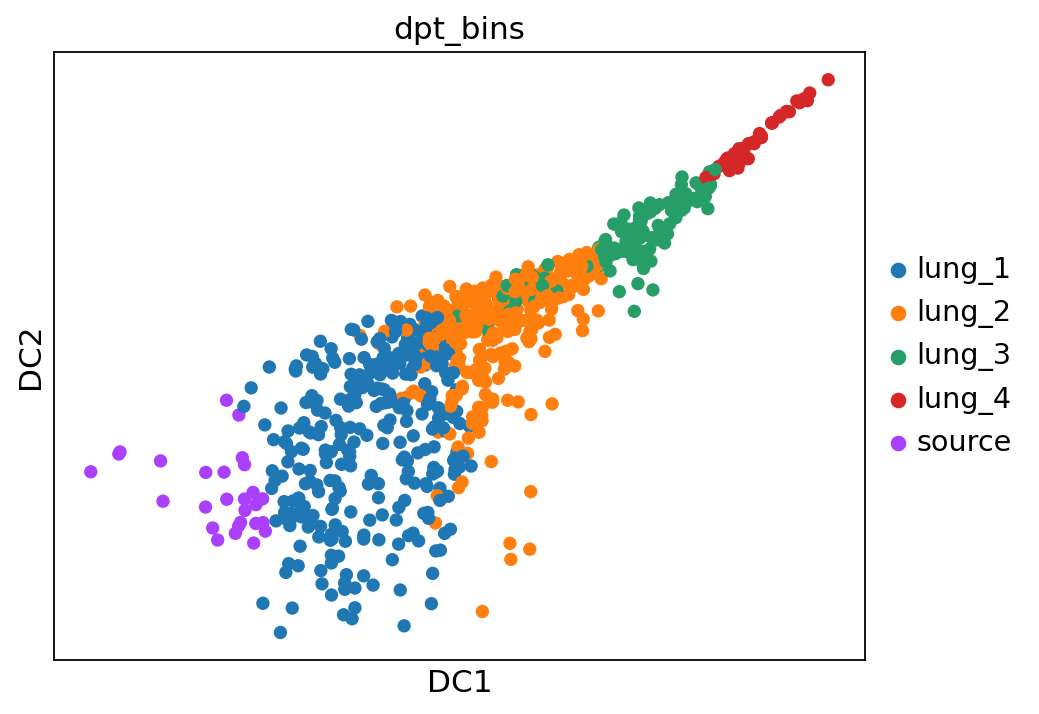

... storing 'dpt_bins' as categorical


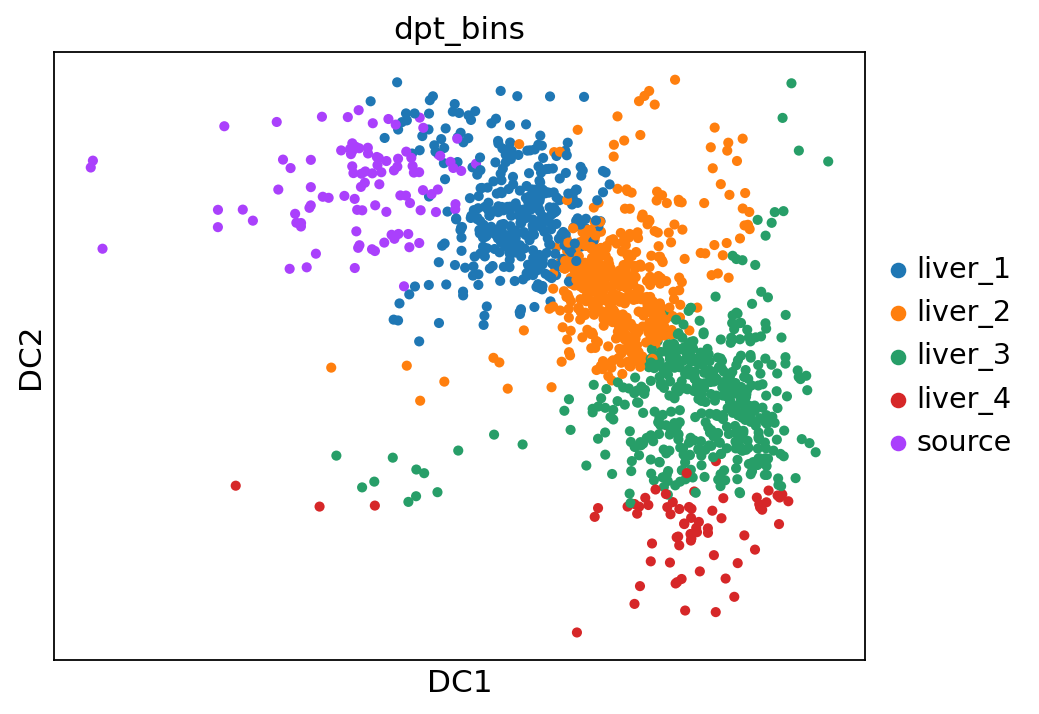

In [18]:
## Recalculate Diffusion Pseudotime for each Branch separately
lung_traj = sub[sub.obs["sub_louvain"].isin(["1"])].copy()
liver_traj = sub[sub.obs["sub_louvain"].isin(["0", "5"])].copy()

#Compute dpt for each of the branches separately (root = cell with lowest DC1 value)
lung_traj.uns['iroot'] = np.argmin(lung_traj.obsm['X_diffmap'][:, 1])
sc.tl.dpt(lung_traj)
liver_traj.uns['iroot'] = np.argmin(liver_traj.obsm['X_diffmap'][:, 1])
sc.tl.dpt(liver_traj)

## Split into 10 bins and combine some smaller bins manually
lung_traj.obs["dpt_bins"] = np.digitize(lung_traj.obs.dpt_pseudotime, np.arange(0, 1, 0.1))
bin_map = {1: "source", 2: "source", 3: "lung_1", 4: "lung_1", 5: "lung_2", 6: "lung_2", 
           7: "lung_3", 8: "lung_3", 9: "lung_4", 10: "lung_4"}
lung_traj.obs["dpt_bins"] = [bin_map[db] for db in lung_traj.obs.dpt_bins]
sc.pl.diffmap(lung_traj, color = "dpt_bins")

liver_traj.obs["dpt_bins"] = np.digitize(liver_traj.obs.dpt_pseudotime, np.arange(0, 1, 0.1))
bin_map = {1: "source", 2: "source", 3: "source", 4: "liver_1", 5: "liver_2", 6: "liver_3",
           7: "liver_3", 8: "liver_4", 9: "liver_4", 10: "liver_4"}
liver_traj.obs["dpt_bins"] = [bin_map[db] for db in liver_traj.obs.dpt_bins]
sc.pl.diffmap(liver_traj, color = "dpt_bins")

... storing 'dpt_bins' as categorical


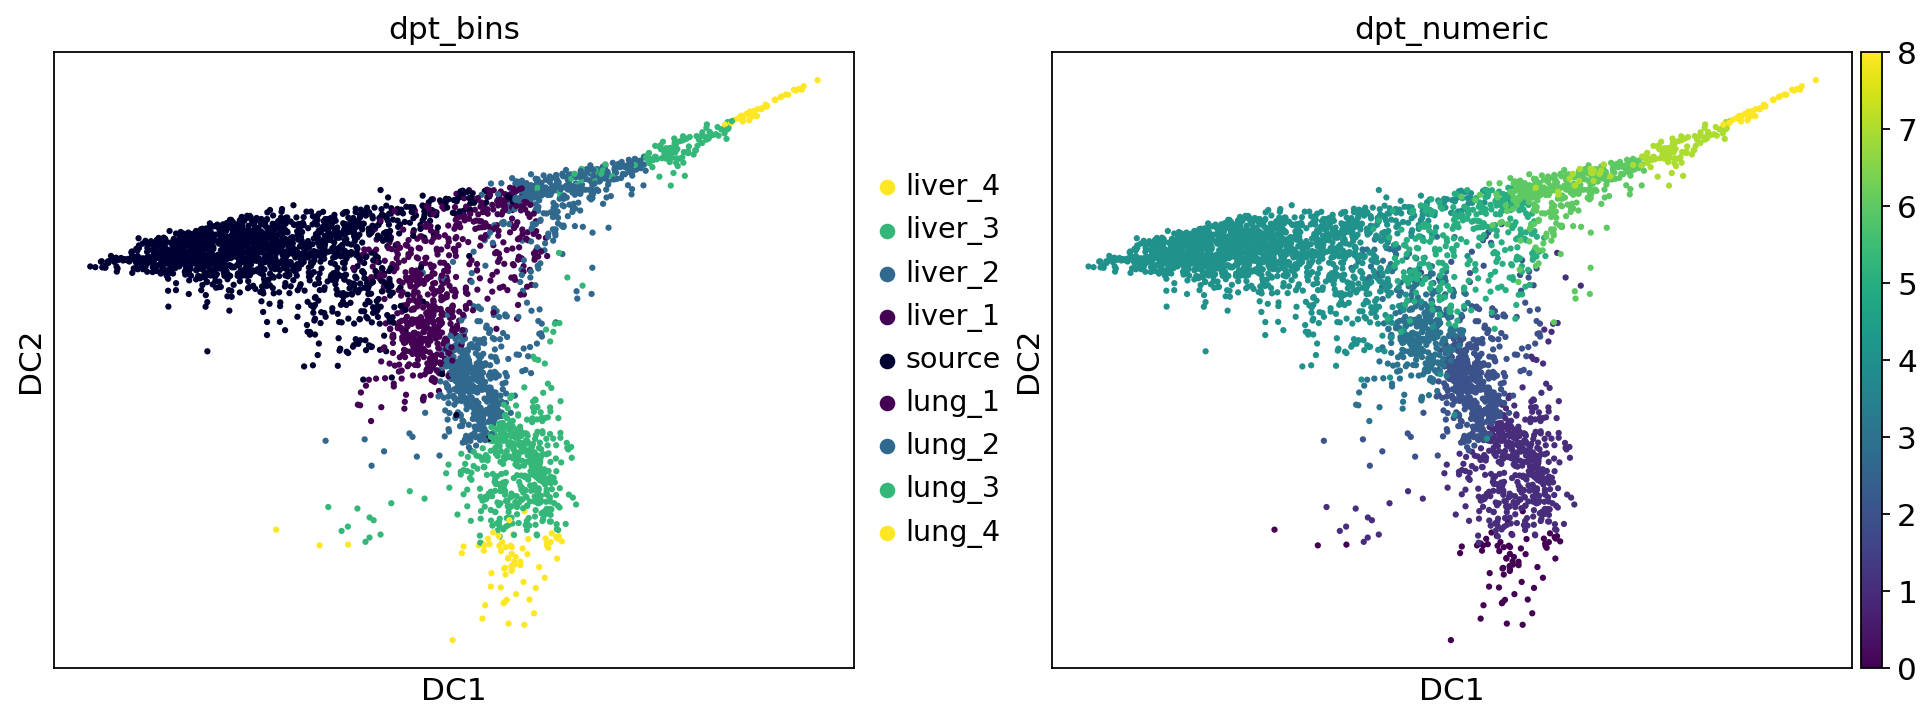

In [20]:
## Add bins to original object again
sub.obs["dpt_bins"] = [lung_traj[c].obs.dpt_bins.values[0] if c in lung_traj.obs_names 
                       else liver_traj[c].obs.dpt_bins.values[0] if c in liver_traj.obs_names 
                       else "source" for c in sub.obs_names]

## Set correct ordering and colouring
sc._utils.sanitize_anndata(sub)
sub.obs.loc[:, "dpt_bins"].cat.reorder_categories(["liver_4", "liver_3", "liver_2", "liver_1", "source", 
                                                   "lung_1", "lung_2", "lung_3", "lung_4"], inplace = True)

## Generate a Palette based on Viridis color map
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cm = colors.LinearSegmentedColormap.from_list("grouping", cmaplist, N = 4)
cols = [cm(i) for i in range(4)]
cols =  cols[::-1][0:7] + ["#000033"] + cols

## Make numeric ordering column for ordering on Heatmap later
order = sub.obs.dpt_bins.cat.categories
sub.obs["dpt_numeric"] = [list(order).index(i) for i in sub.obs["dpt_bins"]]

sc.pl.diffmap(sub, color = ["dpt_bins", "dpt_numeric"], palette = cols)

### Differential Gene Expression Analysis across the trajectories using _diffxpy_

In [32]:
lung_traj = sub[sub.obs["sub_louvain"].isin(["2", "3", "1"])].copy()
liver_traj = sub[sub.obs["sub_louvain"].isin(["2", "3", "0", "5"])].copy()

#Compute dpt for each of the branches separately (root = cell with lowest DC1 value)
lung_traj.uns['iroot'] = np.argmin(lung_traj.obsm['X_diffmap'][:, 1])
sc.tl.dpt(lung_traj)
liver_traj.uns['iroot'] = np.argmin(liver_traj.obsm['X_diffmap'][:, 1])
sc.tl.dpt(liver_traj)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'sub_louvain' as categorical
... storing 'dpt_bins' as categorical
... storing 'merged_trajectory' as categorical


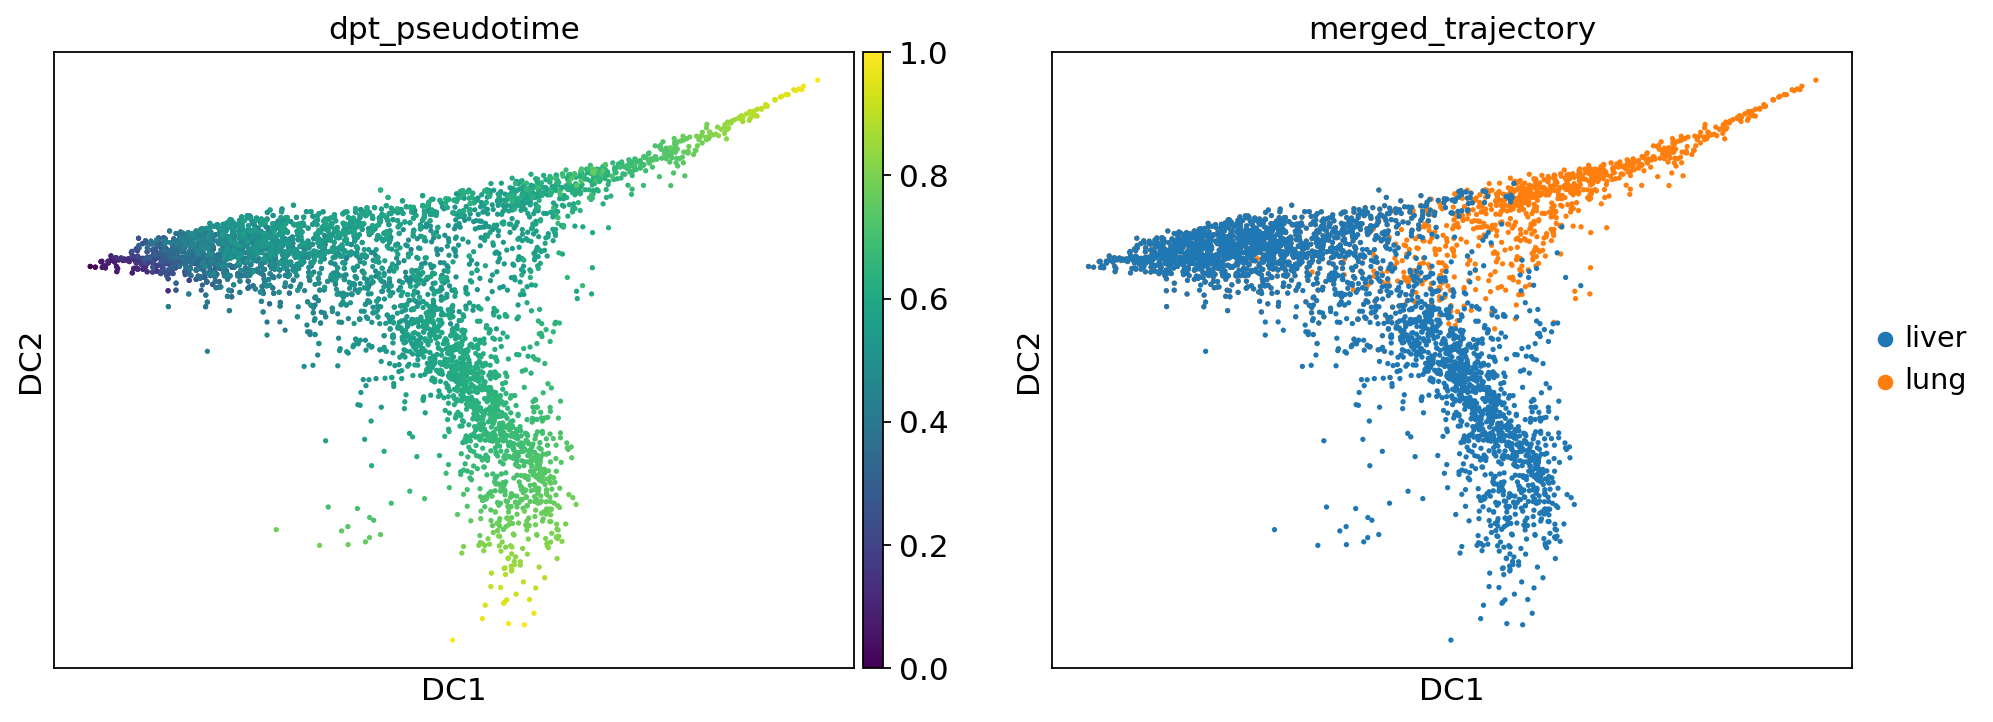

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [33]:
## Merge DPT values into the combined object (double the cells in "source population")
lung_traj.obs["merged_trajectory"] = "lung"
liver_traj.obs["merged_trajectory"] = "liver"
sub_dpt = lung_traj.concatenate([liver_traj], join = "outer", index_unique = None)
sc.pl.diffmap(sub_dpt, color = ["dpt_pseudotime", "merged_trajectory"])

## Ensure Count Data for diffxpy application
sub_dpt.X = sub_dpt.layers["counts"].copy()

## Filter out lowly expressed genes
sc.pp.filter_genes(sub_dpt, min_cells = 5)

In [12]:
import warnings
warnings.filterwarnings("ignore")

print("Started Diffxpy Calculation:\t%s" %codes.timestamp())

sub_de = de.test.continuous_1d(
    data = sub_dpt,
    sample_description = sub_dpt.obs,
    gene_names = sub_dpt.var_names,
    formula_loc = "~ 1 + dpt_pseudotime + merged_trajectory",
    factor_loc_totest = "merged_trajectory",
    continuous = "dpt_pseudotime",
    df = 3, quick_scale = False)

print("Finished Diffxpy Calculation:\t%s" %codes.timestamp())

Started Diffxpy Calculation:	15-08-2020 10:52:35
training location model: True
training scale model: True
iter   0: ll=59345158.094451
iter   1: ll=59132747.661892, converged: 0.00% (loc: 6.60%, scale update: False), in 13.02sec
iter   2: ll=59091917.268787, converged: 0.00% (loc: 36.47%, scale update: False), in 12.60sec
iter   3: ll=59085219.217928, converged: 0.00% (loc: 36.67%, scale update: False), in 10.50sec
iter   4: ll=59083842.889349, converged: 0.00% (loc: 40.34%, scale update: False), in 10.22sec
iter   5: ll=59083407.165463, converged: 0.00% (loc: 56.87%, scale update: False), in 10.04sec
iter   6: ll=17263854.587898, converged: 0.04% (loc: 0.04%, scale update: True), in 208.41sec
iter   7: ll=17190246.284689, converged: 0.04% (loc: 21.02%, scale update: False), in 12.36sec
iter   8: ll=17186152.772148, converged: 0.04% (loc: 48.06%, scale update: False), in 10.94sec
iter   9: ll=17184827.298121, converged: 0.04% (loc: 70.66%, scale update: False), in 9.68sec
iter  10: ll=

iter  86: ll=16702693.641496, converged: 99.47% (loc: 99.55%, scale update: False), in 1.60sec
iter  87: ll=16702693.640742, converged: 99.47% (loc: 99.60%, scale update: False), in 1.41sec
iter  88: ll=16702693.640324, converged: 99.47% (loc: 99.68%, scale update: False), in 1.28sec
iter  89: ll=16702693.640052, converged: 99.47% (loc: 99.73%, scale update: False), in 1.12sec
iter  90: ll=16702635.814288, converged: 99.52% (loc: 99.52%, scale update: True), in 6.67sec
iter  91: ll=16702635.806360, converged: 99.52% (loc: 99.55%, scale update: False), in 1.36sec
iter  92: ll=16702635.804871, converged: 99.52% (loc: 99.61%, scale update: False), in 1.38sec
iter  93: ll=16702635.804305, converged: 99.52% (loc: 99.65%, scale update: False), in 1.42sec
iter  94: ll=16702635.804007, converged: 99.52% (loc: 99.73%, scale update: False), in 1.23sec
iter  95: ll=16702635.803818, converged: 99.52% (loc: 99.73%, scale update: False), in 1.07sec
iter  96: ll=16702591.713290, converged: 99.53% (lo

iter 173: ll=16702516.331831, converged: 99.86% (loc: 99.95%, scale update: False), in 0.63sec
iter 174: ll=16702516.330531, converged: 99.86% (loc: 99.86%, scale update: True), in 5.79sec
iter 175: ll=16702516.329494, converged: 99.86% (loc: 99.87%, scale update: False), in 1.01sec
iter 176: ll=16702516.329136, converged: 99.86% (loc: 99.92%, scale update: False), in 0.89sec
iter 177: ll=16702516.329001, converged: 99.86% (loc: 99.94%, scale update: False), in 0.70sec
iter 178: ll=16702516.328944, converged: 99.86% (loc: 99.94%, scale update: False), in 0.65sec
iter 179: ll=16702516.328918, converged: 99.86% (loc: 99.95%, scale update: False), in 0.60sec
iter 180: ll=16702516.327434, converged: 99.87% (loc: 99.87%, scale update: True), in 5.91sec
iter 181: ll=16702516.326231, converged: 99.87% (loc: 99.89%, scale update: False), in 0.84sec
iter 182: ll=16702516.325846, converged: 99.87% (loc: 99.93%, scale update: False), in 0.79sec
iter 183: ll=16702516.325708, converged: 99.87% (loc

iter 260: ll=16702398.979495, converged: 99.97% (loc: 99.98%, scale update: False), in 0.55sec
iter 261: ll=16702398.979481, converged: 99.97% (loc: 99.98%, scale update: False), in 0.54sec
iter 262: ll=16702398.979478, converged: 99.97% (loc: 99.99%, scale update: False), in 0.68sec
iter 263: ll=16702398.979477, converged: 99.97% (loc: 99.99%, scale update: False), in 0.54sec
iter 264: ll=16702398.976805, converged: 99.98% (loc: 99.98%, scale update: True), in 4.10sec
iter 265: ll=16702398.974542, converged: 99.98% (loc: 99.98%, scale update: False), in 0.58sec
iter 266: ll=16702398.974477, converged: 99.98% (loc: 99.98%, scale update: False), in 0.65sec
iter 267: ll=16702398.974467, converged: 99.98% (loc: 99.98%, scale update: False), in 0.56sec
iter 268: ll=16702398.974464, converged: 99.98% (loc: 99.99%, scale update: False), in 0.55sec
iter 269: ll=16702398.974463, converged: 99.98% (loc: 99.99%, scale update: False), in 0.53sec
iter 270: ll=16702398.972257, converged: 99.98% (lo

iter 347: ll=16702384.410282, converged: 99.99% (loc: 99.99%, scale update: False), in 0.48sec
iter 348: ll=16702384.409562, converged: 99.99% (loc: 99.99%, scale update: True), in 0.67sec
iter 349: ll=16702384.408887, converged: 99.99% (loc: 99.99%, scale update: False), in 0.53sec
iter 350: ll=16702384.408814, converged: 99.99% (loc: 99.99%, scale update: False), in 0.50sec
iter 351: ll=16702384.408807, converged: 99.99% (loc: 99.99%, scale update: False), in 0.53sec
iter 352: ll=16702384.408806, converged: 99.99% (loc: 99.99%, scale update: False), in 0.50sec
iter 353: ll=16702384.408806, converged: 99.99% (loc: 99.99%, scale update: False), in 0.54sec
iter 354: ll=16702384.407963, converged: 99.99% (loc: 99.99%, scale update: True), in 0.72sec
iter 355: ll=16702384.407159, converged: 99.99% (loc: 99.99%, scale update: False), in 0.53sec
iter 356: ll=16702384.407091, converged: 99.99% (loc: 99.99%, scale update: False), in 0.56sec
iter 357: ll=16702384.407086, converged: 99.99% (loc

In [26]:
## Sort by adj p val
res = sub_dge.summary().sort_values(by = ["qval"], ascending = True)
print(res.shape)
res.head()

(13726, 10)


gene  pval  qval     log2fc      mean  zero_mean          grad  \
4815  GUCY1A2   0.0   0.0  44.783906  0.037195      False  2.735455e-08   
6985     MYL3   0.0   0.0   7.826774  0.068564      False  4.512418e-09   
719      APOB   0.0   0.0   4.564425  0.090970      False  4.433984e-08   
4653     GPC3   0.0   0.0   2.246905  0.838898      False  1.524105e-07   
2286      CKB   0.0   0.0   3.602905  2.142281      False  3.376359e-07   

      coef_mle   coef_sd           ll  
4815 -1.668767  0.192303  -568.050157  
6985  1.786459  0.206404  -904.308847  
719   1.274595  0.144049 -1268.162662  
4653  0.399945  0.045683 -5499.727086  
2286  0.640626  0.039027 -8475.683910

In [40]:
## Sanity Check
res[res.gene.isin(["FGB", "SOX2"])]

gene  pval  qval     log2fc      mean  zero_mean          grad  \
4143    FGB   0.0   0.0  24.199895  0.755994      False  2.238002e-07   
11089  SOX2   0.0   0.0  14.195437  0.033162      False  4.103566e-09   

       coef_mle   coef_sd           ll  
4143   2.135196  0.093687 -3623.273945  
11089 -2.199789  0.241271  -542.919916

### Generate Heatmap

In [21]:
## Code adapted from scanpy.tl.heatmap
from scanpy.plotting._anndata import _plot_categories_as_colorblocks, _prepare_dataframe
from scanpy.plotting._anndata import _reorder_categories_after_dendrogram, _check_var_names_type
from scanpy.plotting._anndata import _plot_dendrogram
from scanpy.plotting._anndata import _plot_categories_as_colorblocks, _plot_colorbar
from matplotlib import gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm

def avg_heatmap(adata, var_names, groupby = None, log = False, use_raw = False, num_categories = 7,
                order = None, gene_symbols = None, layer = None, scale = True, save = None, cmap = "viridis",
                dendrogram = True, colorbar_width = 0.2, categorical = True, figsize = (10, 5), ticksize = 10):

    categories, obs_tidy = _prepare_dataframe(adata, var_names, groupby, use_raw, log, num_categories,
                                                  gene_symbols = gene_symbols, layer = layer)
    var_group_labels = None
    var_group_positions = None
    var_names, var_group_labels, var_group_positions = _check_var_names_type(var_names,
                                                                             var_group_labels, var_group_positions)
    obs_means = obs_tidy.groupby(level=0).mean()
    
    if scale == True:
        obs_means -= obs_means.min(0)
        obs_means = (obs_means / obs_means.max(0)).fillna(0)
    groupby_colors = adata.uns[groupby + "_colors"]

    if order is not None:
        obs_means.index = obs_means.index.reorder_categories(order)
    else:
        obs_means = obs_means.sort_index()

    dendro_height = 0
    groupby_height = 0.13 if categorical else 0
    width, height = figsize
    heatmap_height = height - (dendro_height + groupby_height)

    height_ratios = [dendro_height, heatmap_height, groupby_height]

    if var_group_positions is not None and len(var_group_positions) > 0:
        width_ratios = [width, 0.14, colorbar_width]
    else:
        width_ratios = [width, 0, colorbar_width]

    fig = plt.figure(figsize=(width, height))
    axs = gridspec.GridSpec(nrows=3, ncols=3, wspace=0.25 / width, hspace=0.3 / height,
                            width_ratios=width_ratios, height_ratios=height_ratios)

    # plot heatmap
    heatmap_ax = fig.add_subplot(axs[1, 0])

    if order is not None:
        obs_means = obs_means.reindex(order, axis = 0)
    
    im = heatmap_ax.imshow(obs_means.T.values, aspect = 'auto', cmap = cmap)#, **kwds)  ## adapted for mean
    heatmap_ax.set_xlim(-0.5, obs_means.shape[0] - 0.5)                    ## adapted for mean
    heatmap_ax.set_ylim(obs_means.shape[1] - 0.5, - 0.5)                   ## adapted for mean

    heatmap_ax.tick_params(axis='x', bottom=False, labelbottom=False)
    heatmap_ax.set_xlabel('')
    heatmap_ax.grid(False)
    heatmap_ax.tick_params(axis='y', labelsize='small', length = 1)
    heatmap_ax.set_yticks(np.arange(len(var_names)))
    heatmap_ax.set_yticklabels(var_names, rotation=0, size = ticksize)
    heatmap_ax.set

    if categorical:
        groupby_ax = fig.add_subplot(axs[2, 0])

        groupby = obs_means.index.name
        groupby_cmap = ListedColormap(groupby_colors, groupby + '_cmap')
        norm = BoundaryNorm(np.arange(groupby_cmap.N+1)-.5, groupby_cmap.N)

        value_sum = -0.5 
        ticks = []
        labels = []
        label2code = {}

        for code, (label, value) in enumerate(obs_means.index.value_counts(sort = False).iteritems()):
            ticks.append(value_sum + (value / 2))
            labels.append(label)
            value_sum += value
            label2code[label] = code
        groupby_ax.grid(False)

        groupby_ax.imshow(np.matrix([label2code[lab] for lab in obs_means.index]), aspect='auto', 
                          cmap = groupby_cmap, norm = norm)
        if len(labels) > 1:
            groupby_ax.set_xticks(ticks)
            if max([len(x) for x in labels]) < 3:
                # if the labels are small do not rotate them
                rotation = 0
            else:
                rotation = 90
            groupby_ax.set_xticklabels(labels, rotation=rotation)

        # remove x ticks, y ticks and labels
        groupby_ax.tick_params(axis='x', bottom = False, labelsize = ticksize)
        groupby_ax.tick_params(axis='y', left = False, labelleft = False)

        # remove surrounding lines
        groupby_ax.spines['right'].set_visible(False)
        groupby_ax.spines['top'].set_visible(False)
        groupby_ax.spines['left'].set_visible(False)
        groupby_ax.spines['bottom'].set_visible(False)
        groupby_ax.set_xlabel(groupby)

        # add lines to main heatmap
        line_positions = np.cumsum(obs_means.index.value_counts(sort=False))[:-1]
        heatmap_ax.vlines(line_positions - 0.505, -1, len(var_names) + 1, lw = 1)
        
    _plot_colorbar(im, fig, axs[1, 2])
    if save:
        fig.savefig(save)
    plt.show()
    plt.close()


In [29]:
## Read in Diffxpy result table from above
res = pd.read_excel(folder + "Suppl_Table_8_diffxpy_FE_ELP_traj.xlsx", index_col = 0)

res = res.sort_values(by = ["qval", "log2fc"], ascending = [True, False])
de_genes = res.index.values[0:100]

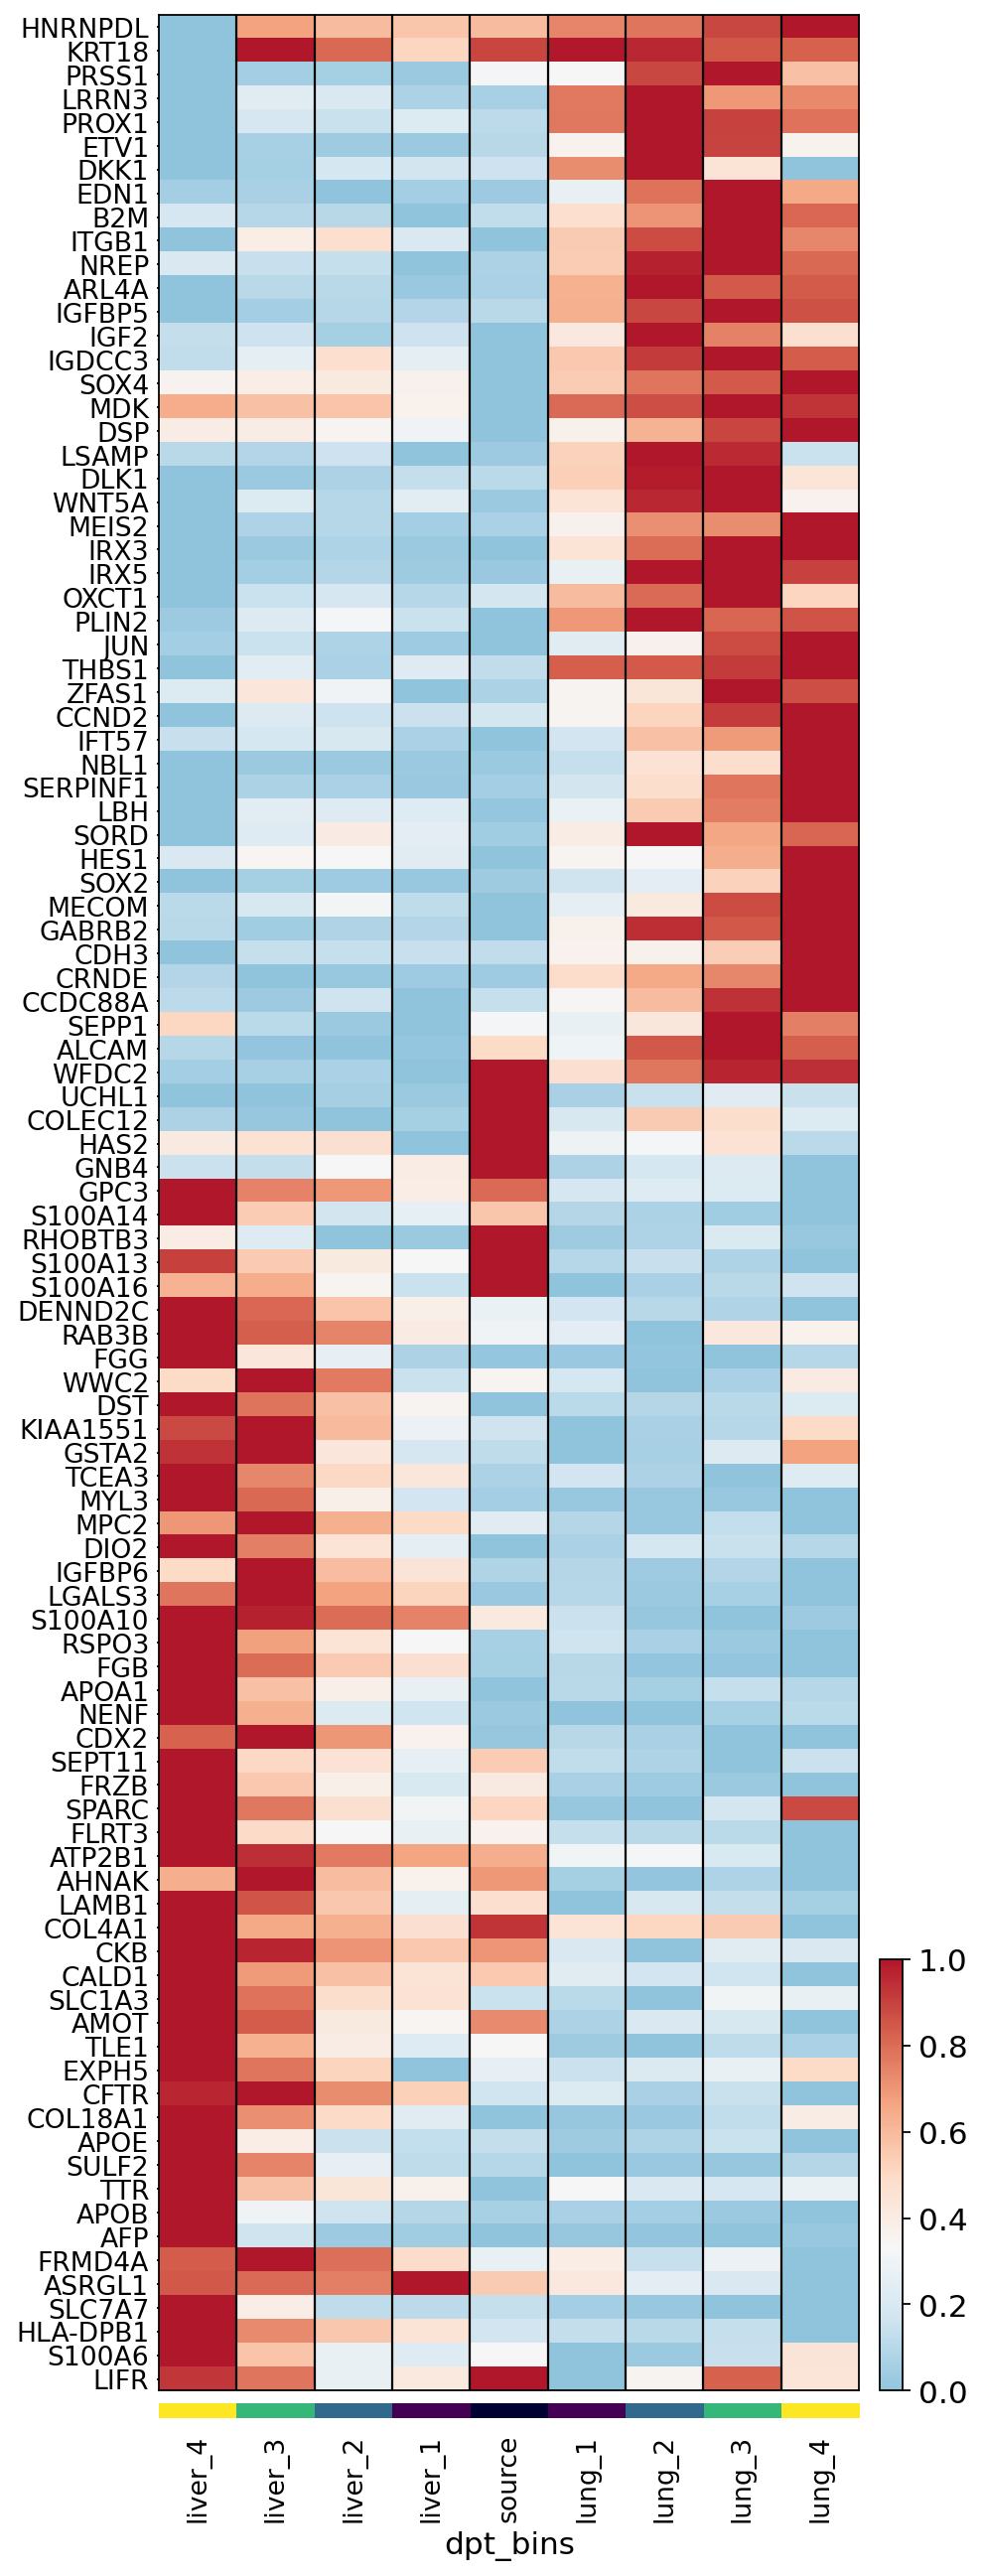

In [30]:
## Order the gene list hierarchically
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

genes = [sub.var_names.get_loc(i) for i in de_genes]
expr = pd.DataFrame(sub.X[:, genes], columns = de_genes)
expr["dpt"] = sub.obs["dpt_numeric"].values
expr.sort_values(by = "dpt", inplace = True)
expr = expr.T

## Cluster the rows
c_dist = pdist(expr) # computing the distance
c_link = linkage(expr,  metric='correlation', method='complete')
B = dendrogram(c_link, labels = expr.index.values, no_plot = True)
order = B["ivl"]
order = np.delete(order, order.index("dpt"), axis = 0)

avg_heatmap(sub, var_names = order, groupby = "dpt_bins", cmap = hmap, use_raw = True,
            ticksize = 12, figsize = (6, 20), scale = True)

### Figure 4 f - Average expression per diffusion pseudo time bin across two trajectories

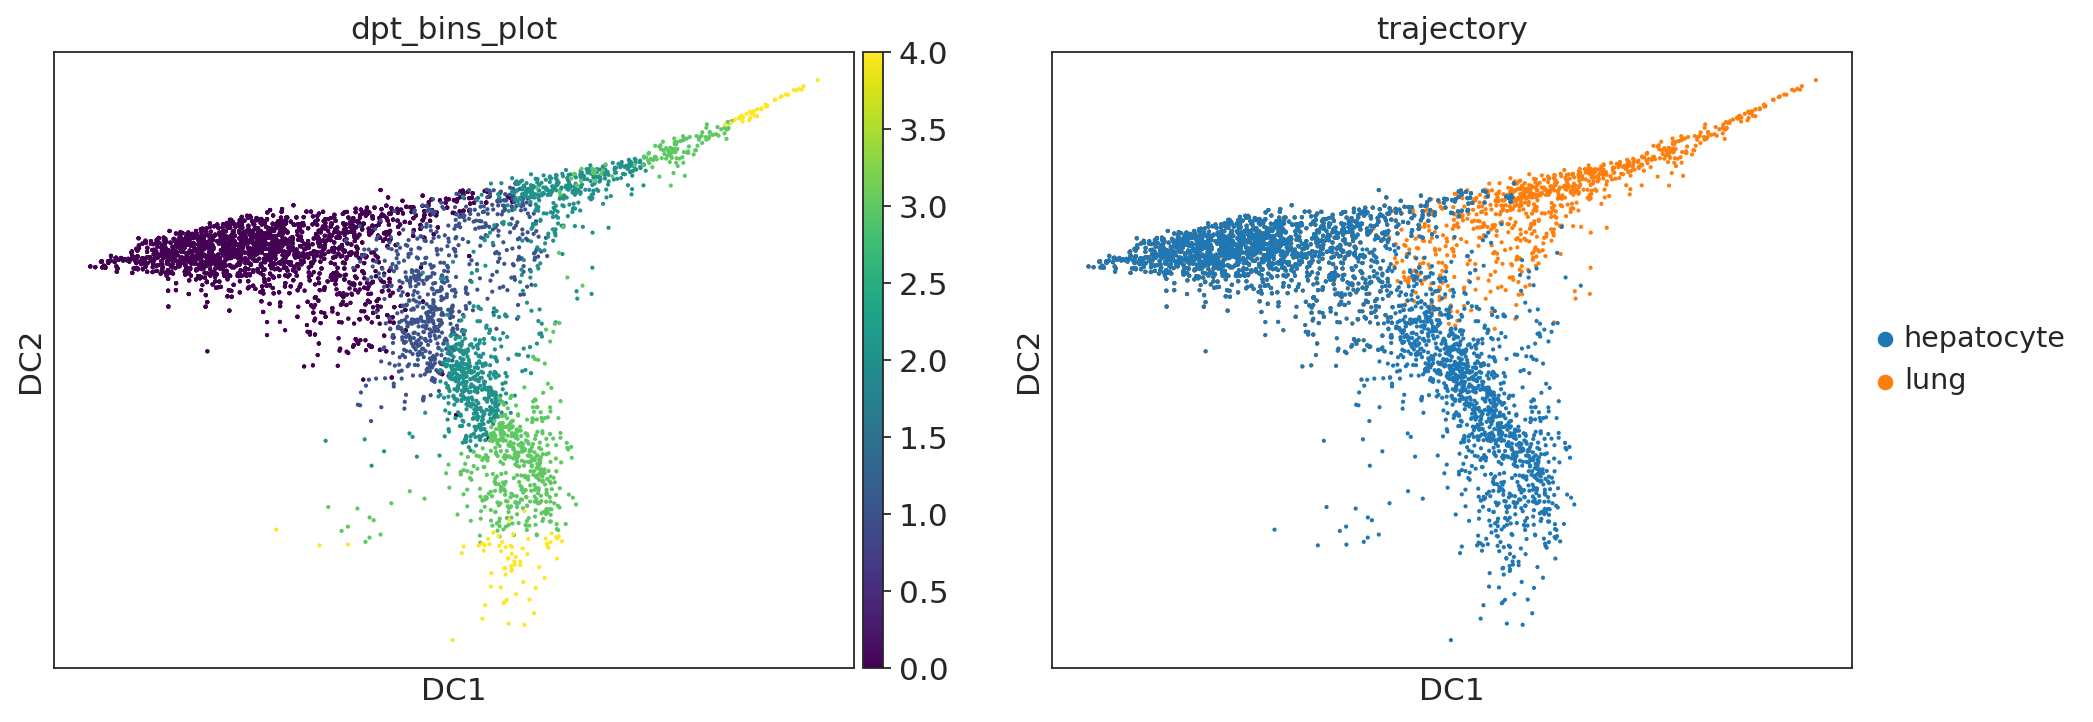

In [49]:
sub_dpt.obs["trajectory"] = ["lung" if (d.startswith("lung")) or d == "source" else "hepatocyte" 
                              for d in sub_dpt.obs.dpt_bins]

tmp = sub_dpt[sub_dpt.obs.dpt_bins == "source"].copy()
tmp.obs["trajectory"] = "hepatocyte"
sub_dpt = sub_dpt.concatenate([tmp], join = "outer")

sc._utils.sanitize_anndata(sub_dpt)
sub_dpt.obs["dpt_bins"].cat.reorder_categories(['liver_4', 'liver_3', 'liver_2', 'liver_1', "source",
                                                 'lung_1', 'lung_2', 'lung_3', 'lung_4'], inplace = True)
## Introduce new column to be used for ordering
sub_dpt.obs["dpt_bins_plot"] = [0 if d == "source" else int(re.findall("[\d]+", d)[0])
                                 for d in sub_dpt.obs.dpt_bins]
sc.pl.diffmap(sub_dpt, color = ["dpt_bins_plot", "trajectory"])

In [38]:
def generate_expr_table(adata, xlabel = "days", typ = None):
    genExp = pd.DataFrame(adata.raw.X.todense(), index = adata.obs_names, columns = adata.raw.var_names)
    
    genExp["identifier"] = adata.obs["sample"]
    genExp[xlabel] = adata.obs[xlabel]
    genExp[typ] = adata.obs[typ]
    return genExp

def line_plot_avg_expression(genExp, gene, order, xlabel = "days", typ = "typ", cluster = None,
                                     figsize = (15, 6), cols = None, tick_size = 12, label_size = 15):
    
    data = genExp.groupby(["identifier", typ, xlabel])[gene].mean().reset_index()
    cat = sb.catplot(data = data, x = xlabel, y = gene, kind = "point", hue = typ, palette = cols)
    cat.set(xticks = np.unique(data.loc[:, xlabel]))
    cat.set_xticklabels(order)
    cat.fig.set_size_inches(figsize)
        
    cat.ax.set_title(gene, size = label_size)
    cat.ax.set_xlabel(xlabel, size = label_size)
    cat.ax.set_ylabel("avg expression", size = label_size)
    cat.ax.tick_params(labelsize = tick_size)

    plt.show()
    plt.close()

In [42]:
sb.set_style("ticks")
xlabel = "dpt_bins_plot"
order = np.arange(0, 5)
condition = "trajectory"

genExp = generate_expr_table(sub_dpt, xlabel = xlabel, typ = condition)

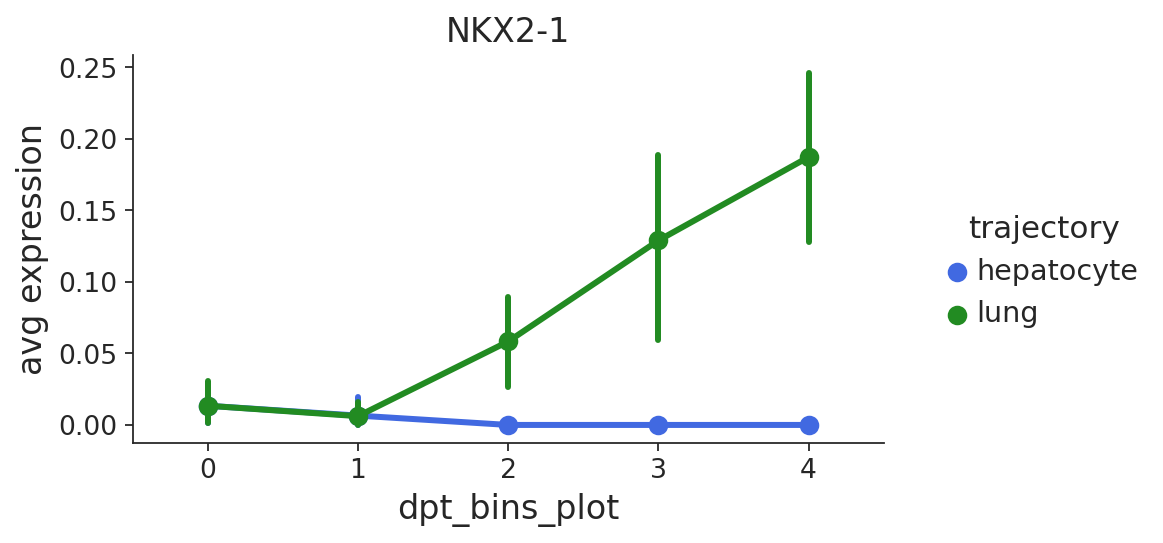

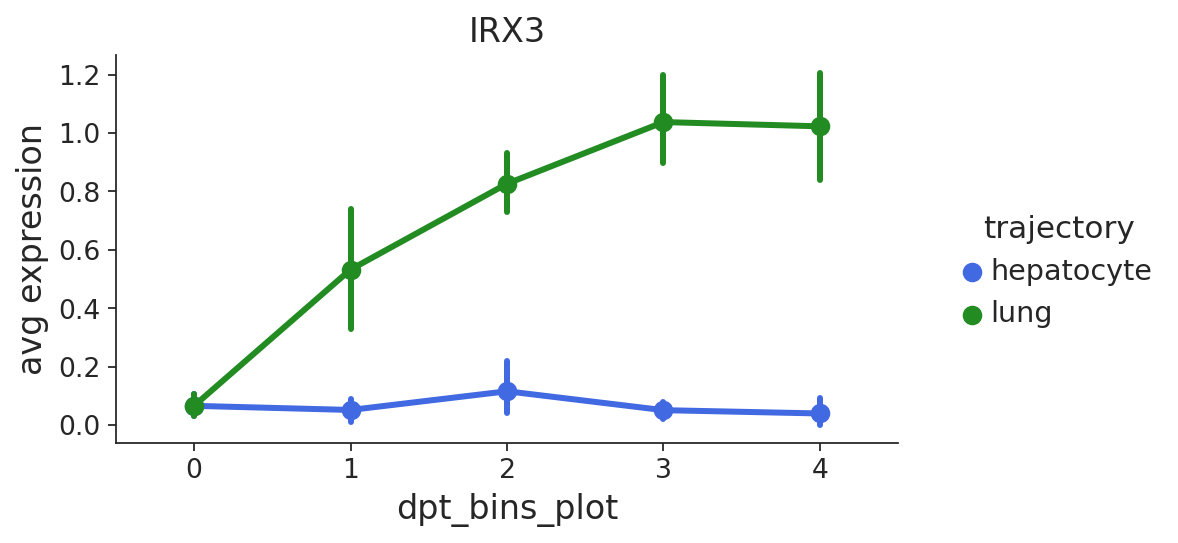

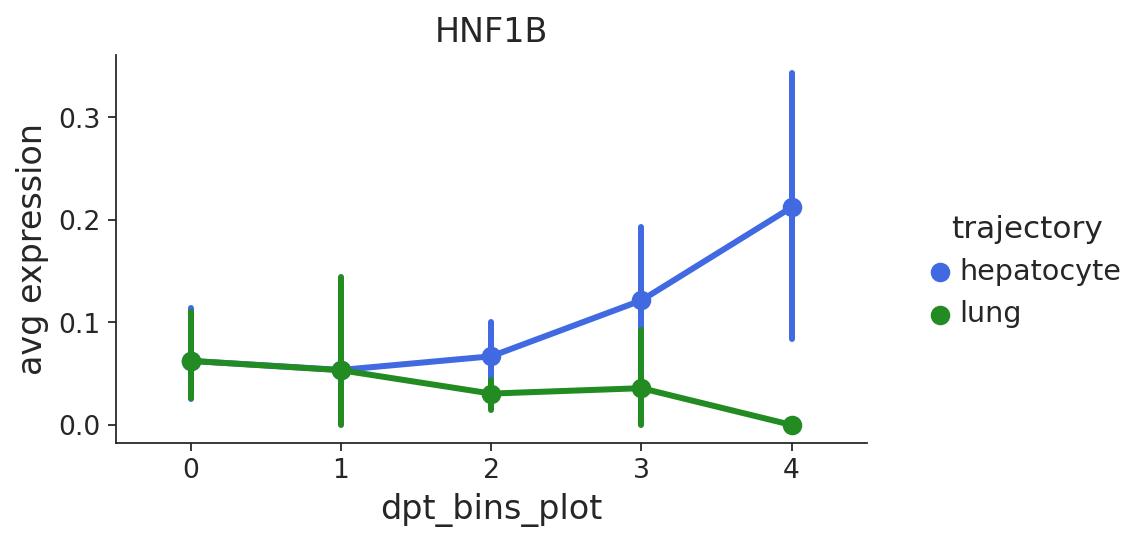

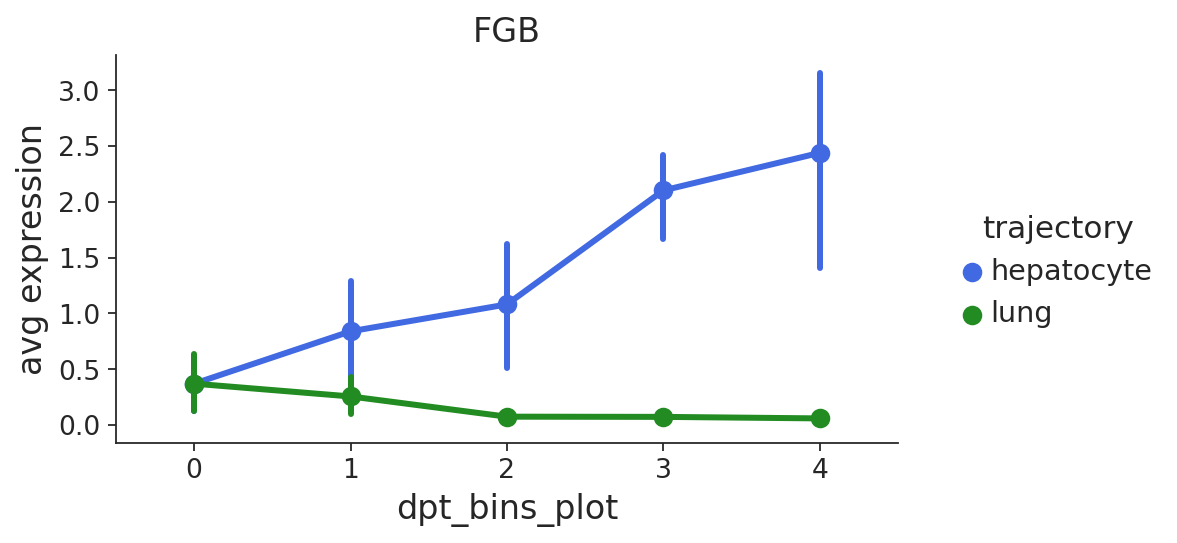

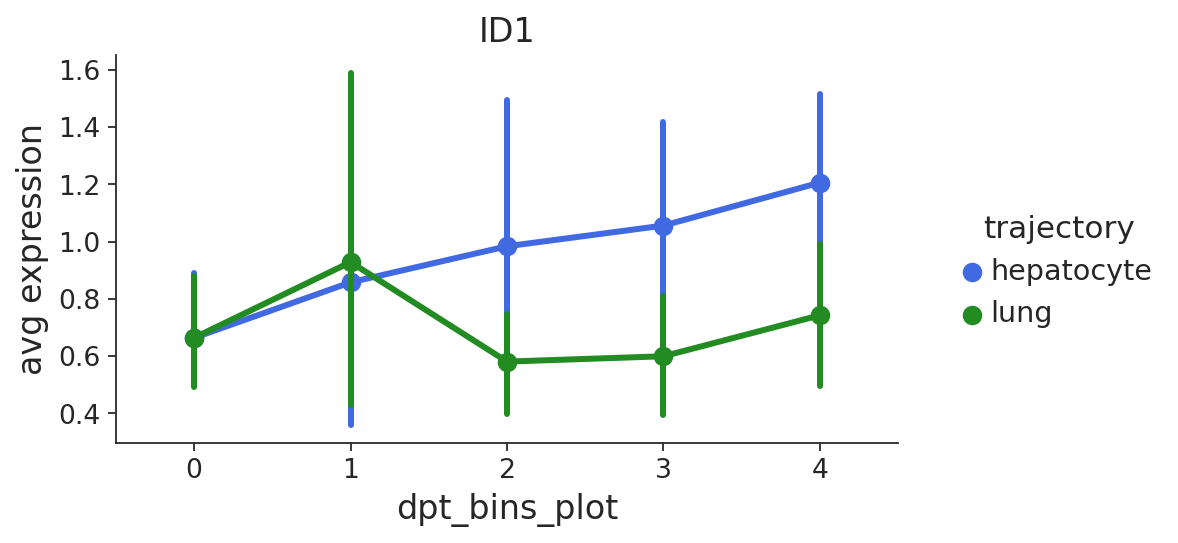

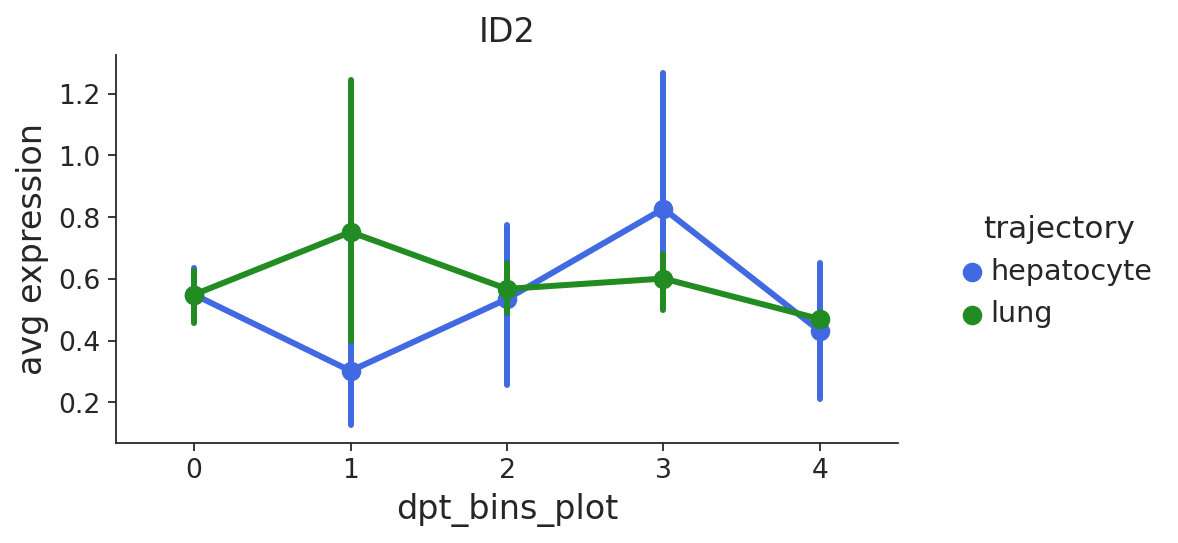

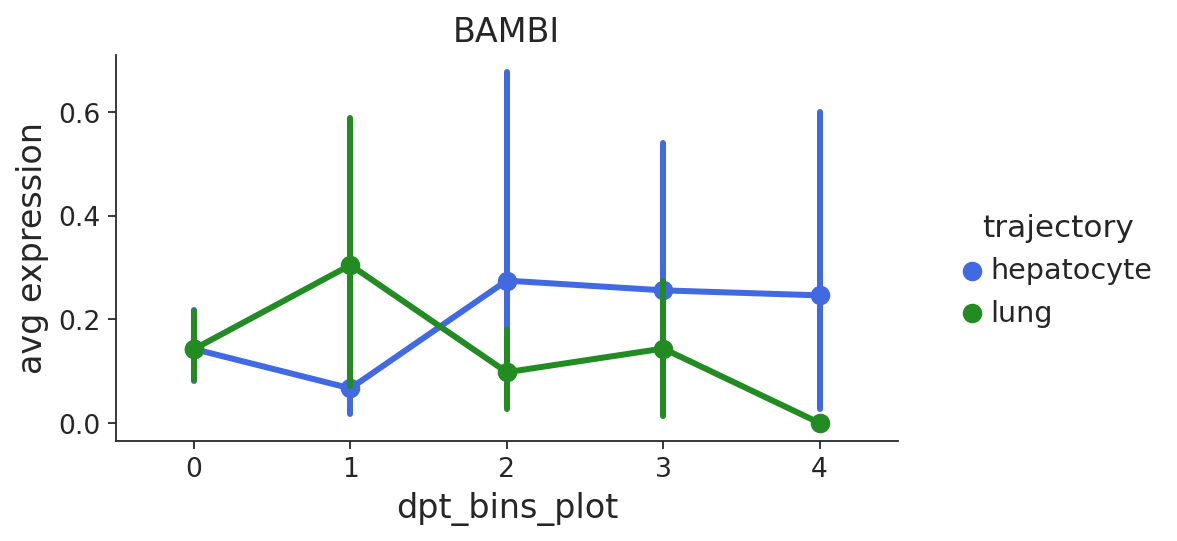

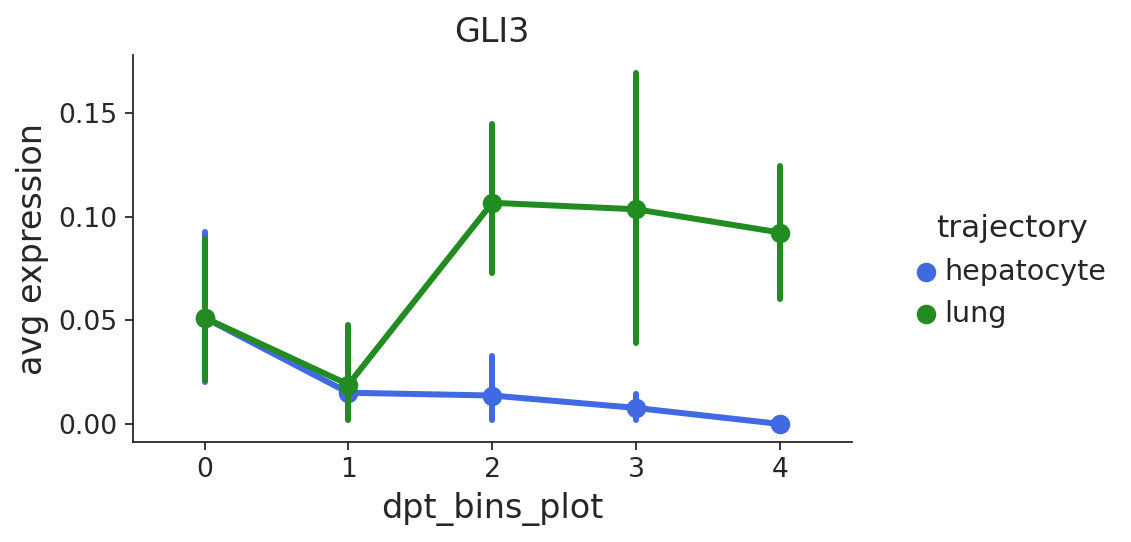

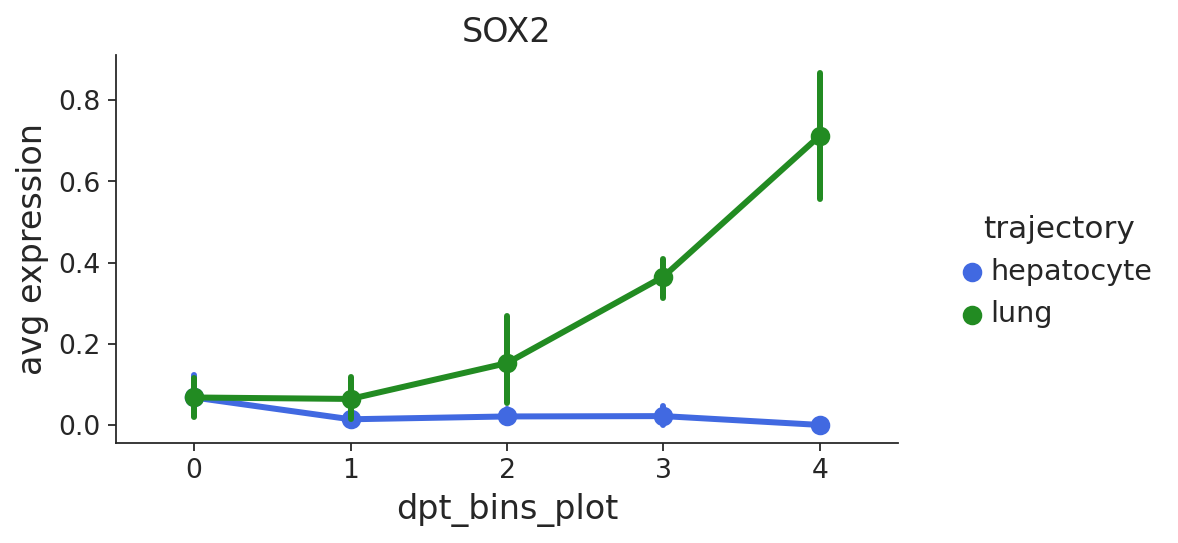

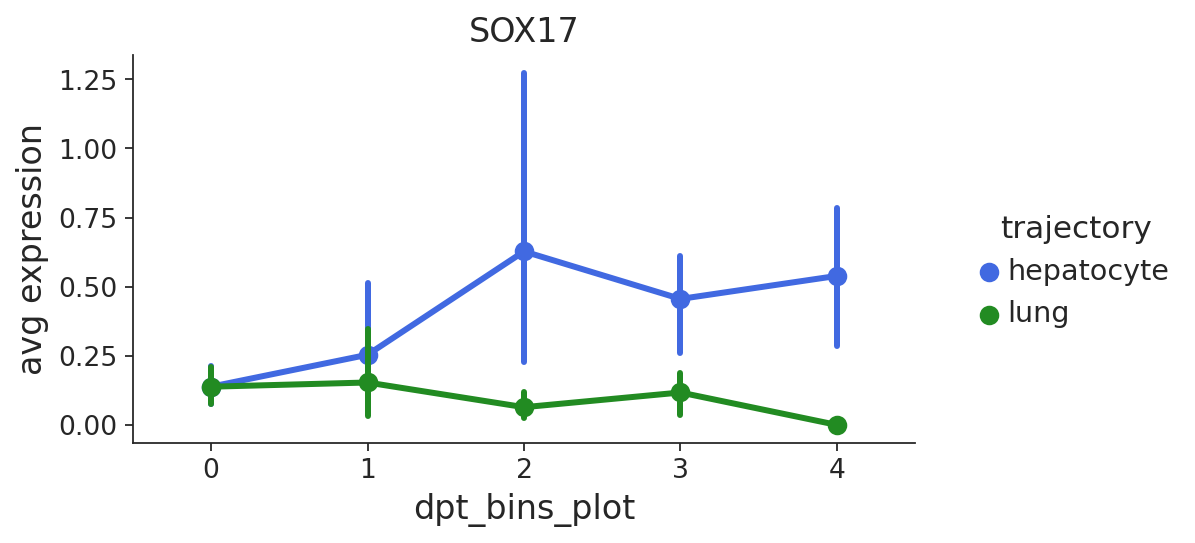

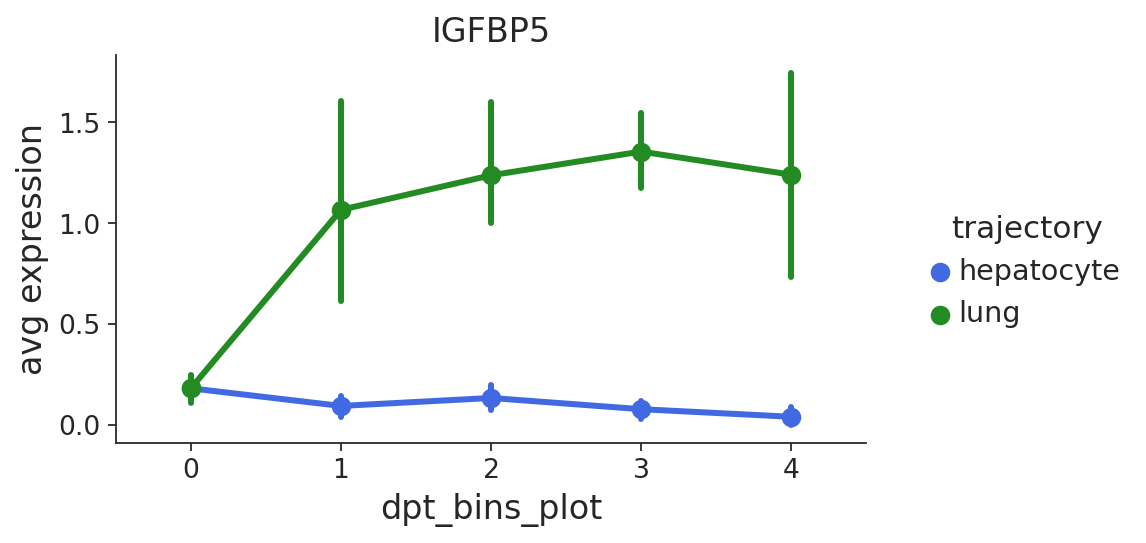

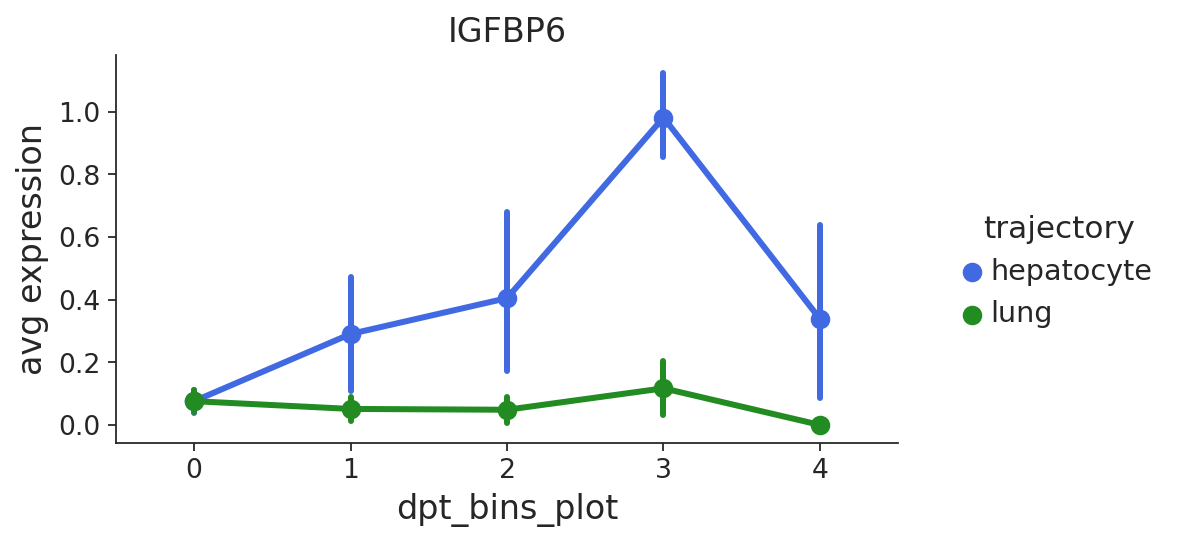

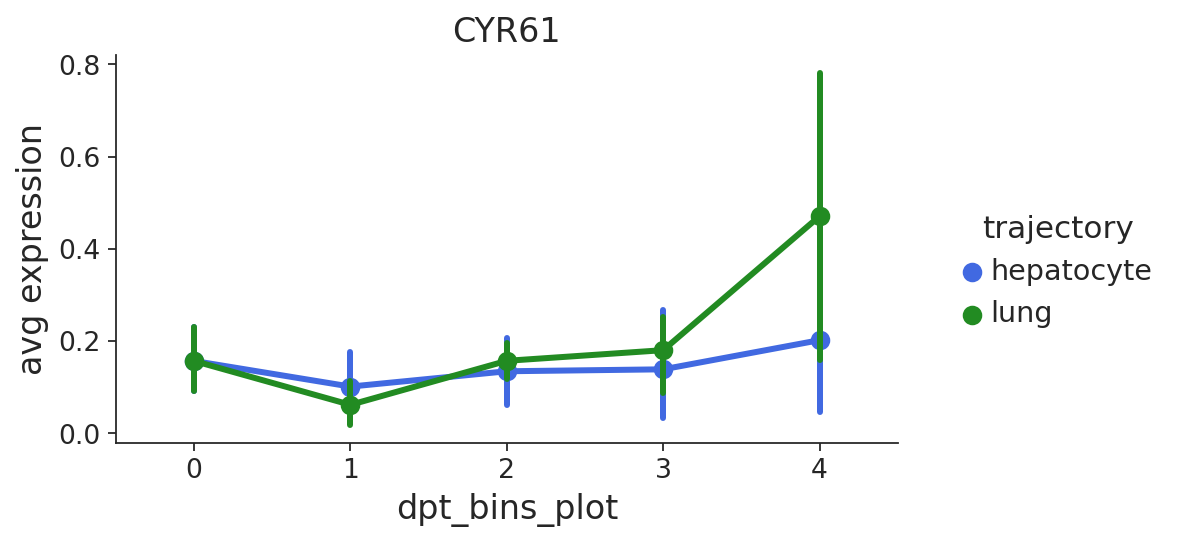

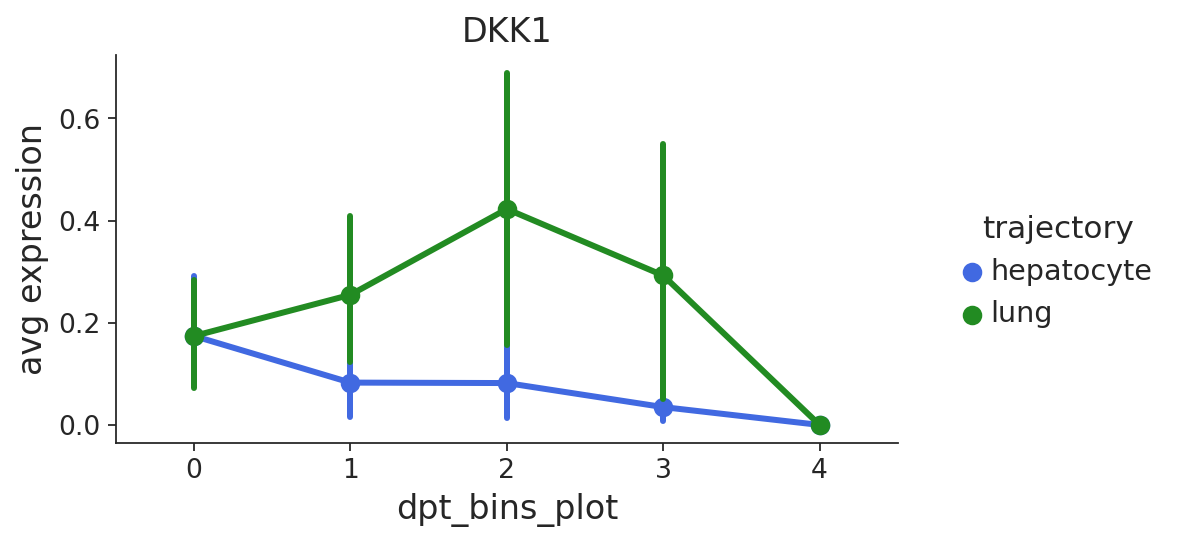

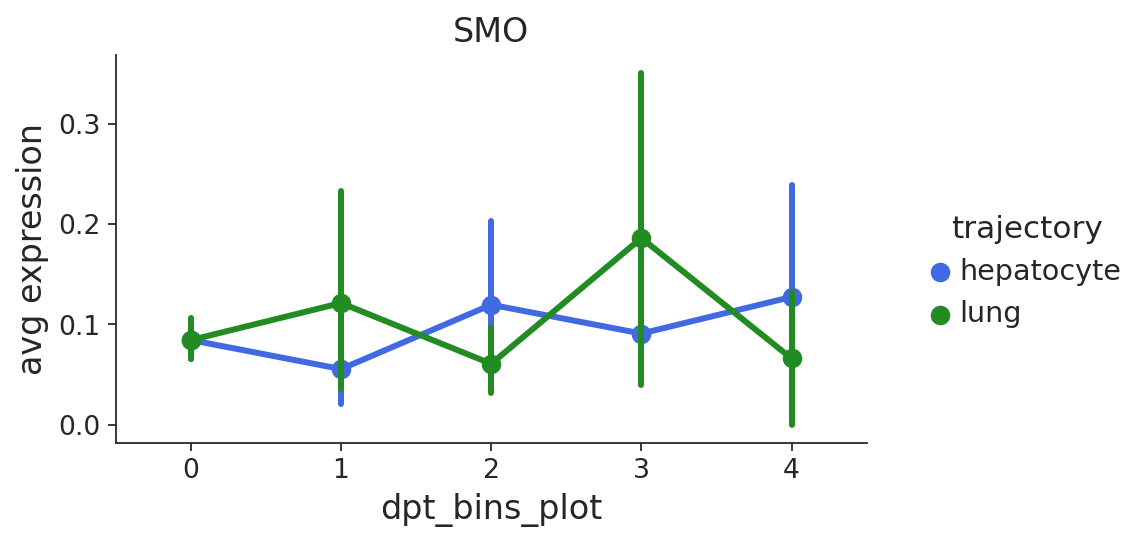

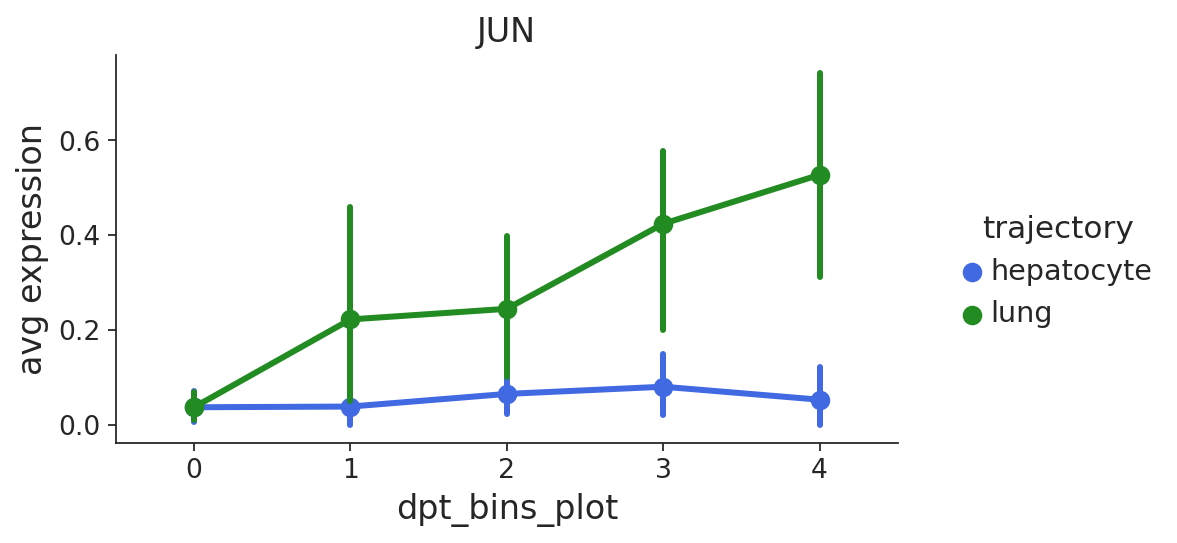

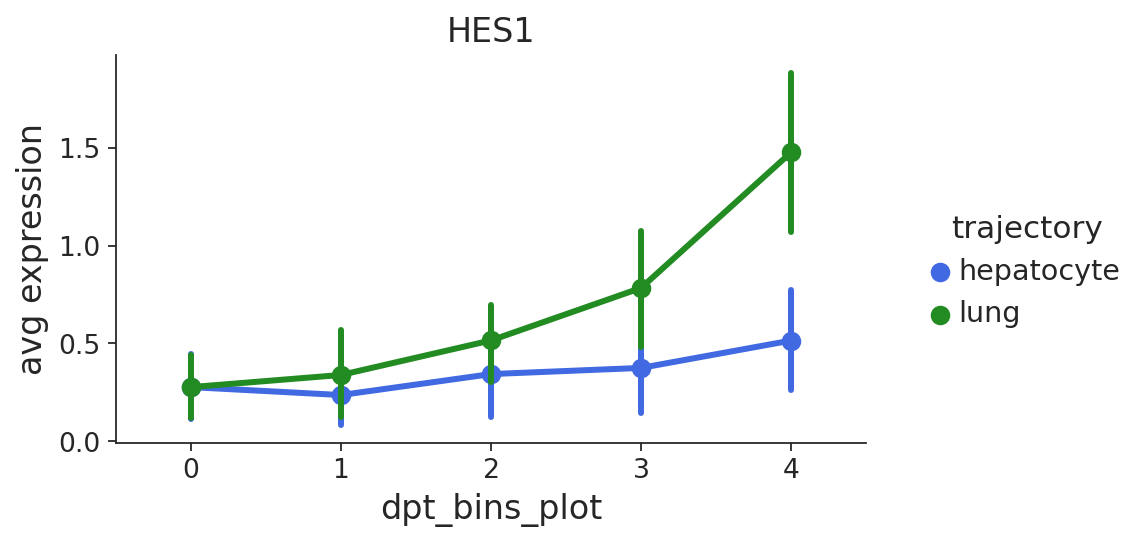

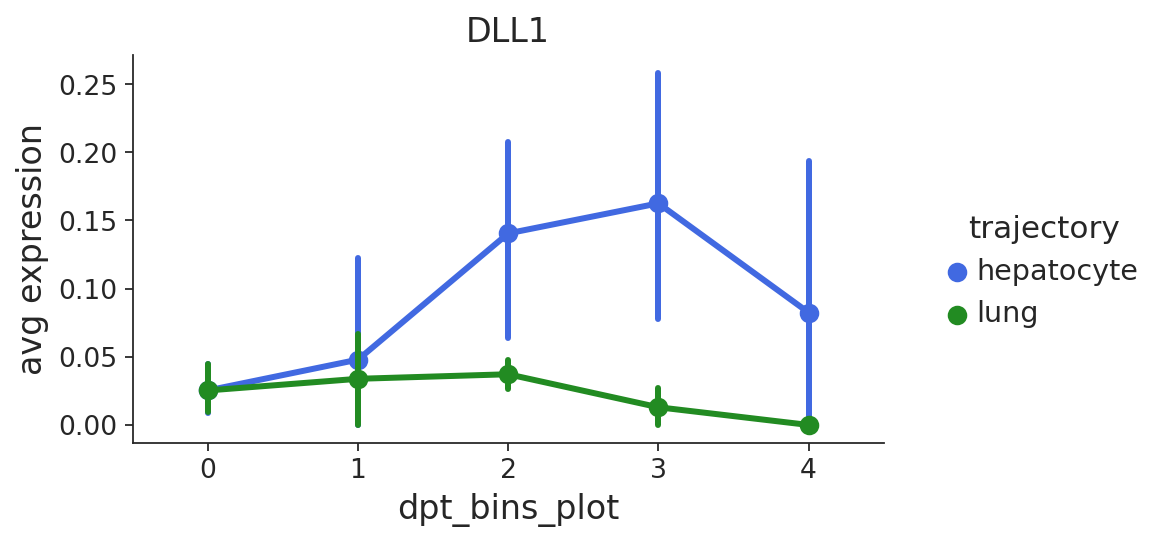

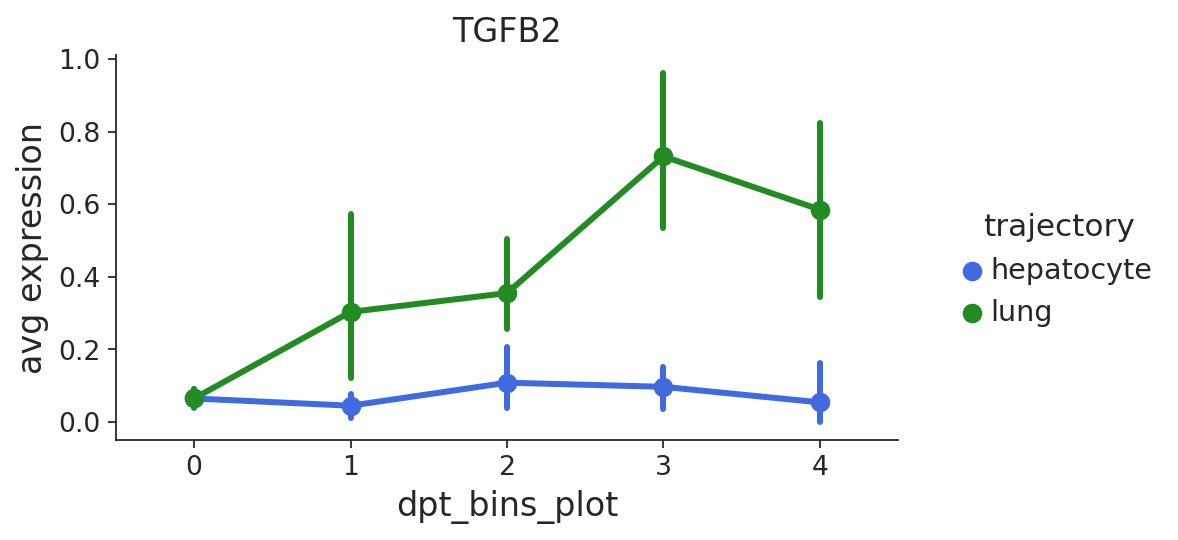

In [47]:
genes = ["NKX2-1", "IRX3", "HNF1B", "FGB", "ID1", "ID2", "BAMBI", "GLI3", "SOX2", "SOX17",
         "IGFBP5", "IGFBP6", "CYR61", "DKK1", "SMO", "JUN", "HES1", "DLL1", "TGFB2"]

for gene in genes:
    line_plot_avg_expression(genExp, gene, order = order, xlabel = xlabel, typ = condition, 
                             cols = ["royalblue", "forestgreen"], tick_size = 12, label_size = 15, figsize = (8, 3))